In [2]:
import torch
import numpy as np

"""Initialize appropriate computing device and random number generator"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

rng = np.random.default_rng(seed=42)

Using device: cuda


In [3]:
import matplotlib.pyplot as plt
from scipy.linalg import hadamard

def generate_hadamard_matrix(size: int) -> np.ndarray:
    """Generate normalized Hadamard matrix of given size.
    
    Args:
        size (int): Matrix size (must be power of 2).
    
    Returns:
        np.ndarray: Normalized Hadamard matrix (values in [0, 1]) 
                              or None if size is invalid.
    """
    try:
        return (hadamard(size) + 1) / 2  # Normalize to [0, 1] range
    except ValueError:
        raise ValueError(f"Size must be a power of 2, got {size}")


def generate_hadamard_masks(size: int, num_masks: int) -> np.ndarray:
    """Generate random Hadamard masks.
    
    Args:
        size (int): Base size (N) for N x N masks.
        num_masks (int): Number of masks to generate..
    
    Returns:
        np.ndarray: Array of shape (num_masks, size, size)
    """
    full_size = size ** 2
    hadamard_matrix = generate_hadamard_matrix(full_size)
    
    random_indices = rng.choice(full_size, num_masks, replace=False)
    return hadamard_matrix[random_indices].reshape(num_masks, size, size)


def visualize_mask(mask: np.ndarray, title: str = "Hadamard Mask") -> None:
    """Visualize binary mask.
    
    Args:
        mask (np.ndarray): 2D array to visualize.
        title (str, optional): Plot title. Defaults to "Hadamard Mask".
    """
    plt.figure()
    ax = plt.gca()
    
    ax.imshow(mask, cmap='gray')
    ax.set_title(title)
    ax.tick_params(
        axis='both', 
        which='both', 
        bottom=False, 
        left=False,
        labelbottom=False, 
        labelleft=False
    )

    plt.tight_layout()
    plt.show()

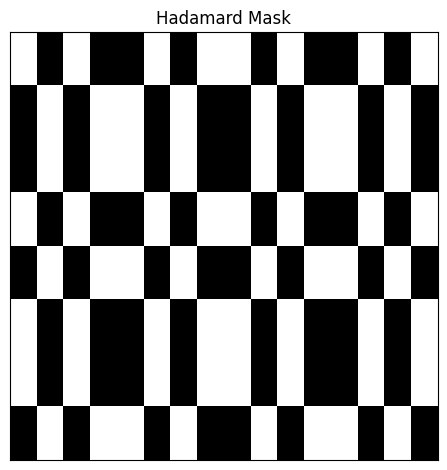

In [4]:
masks = generate_hadamard_masks(32, 1024)
visualize_mask(masks[0])
masks = masks.reshape(1024, -1)

In [5]:
from scipy.fftpack import dct, idct

def dct2(x: np.ndarray) -> np.ndarray:
    """Perform 2D Discrete Cosine Transform.
    
    Args:
        x (np.ndarray): Input 2D array.
    
    Returns:
        np.ndarray: 2D DCT transformed array (not shifted).
    """
    return dct(dct(x.T, norm='ortho').T, norm='ortho')


def idct2(x: np.ndarray) -> np.ndarray:
    """Perform 2D Inverse Discrete Cosine Transform.
    
    Args:
        x (np.ndarray): Input 2D array.
    
    Returns:
        np.ndarray: 2D IDCT transformed array.
    """
    return idct(idct(x.T, norm='ortho').T, norm='ortho')


def create_dct_basis(size: int) -> np.ndarray:
    """Create DCT basis matrix.
    
    Args:
        size (int): Size of the basis (will create size² x size² matrix).
    
    Returns:
        np.ndarray: DCT basis matrix of shape (size², size²).
    """
    basis_size = size ** 2
    basis = np.zeros((basis_size, basis_size))
    
    for i in range(size):
        for j in range(size):
            x = np.zeros((size, size))
            x[i, j] = 1
            basis[i*size + j, :] = idct2(x).flatten()
    
    return basis


def calculate_coherence(measurement_matrix: np.ndarray, basis_matrix: np.ndarray,) -> np.ndarray:
    """Calculate and visualize coherence between matrices.
    
    Args:
        measurement_matrix (np.ndarray): Measurement matrix (M x N).
        basis_matrix (np.ndarray): Basis matrix (N x N).
    
    Returns:
        np.ndarray: Sorted matrix.
    """
    # Calculate coherence
    products = np.sqrt(1024)*np.dot(measurement_matrix, basis_matrix)
    products /= np.diag(np.dot(measurement_matrix, measurement_matrix.T))
    
    max_coherence = np.max(np.abs(products), axis=1)
    sorted_indices = np.argsort(max_coherence)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].plot(max_coherence)
    axes[0].set_title('Coherence (Original Order)')
    axes[0].set_ylabel('Coherence')
    axes[0].grid(True)
    
    axes[1].plot(np.sort(max_coherence))
    axes[1].set_title('Sorted Coherence')
    axes[1].grid(True)
    
    plt.show()
    plt.tight_layout()

    sorted_matrix = measurement_matrix[sorted_indices]
    
    return sorted_matrix

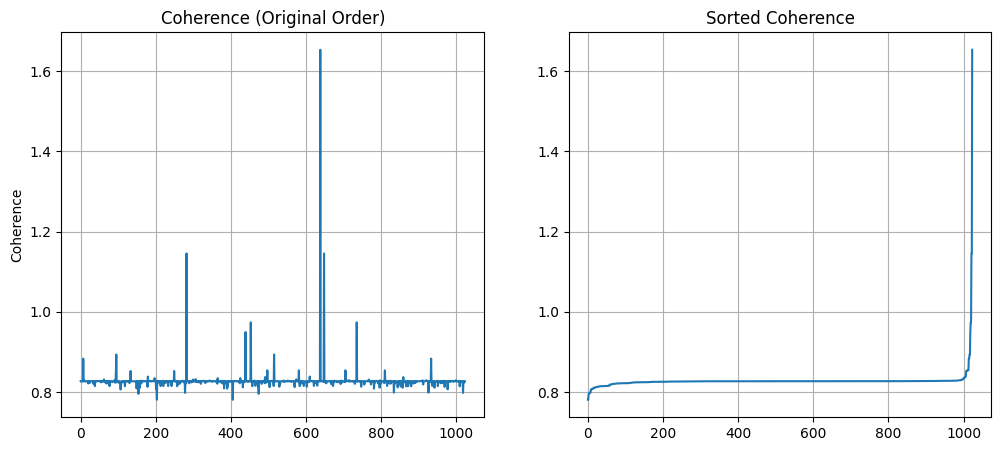

<Figure size 640x480 with 0 Axes>

In [6]:
dct_basis = create_dct_basis(32)
masks_sorted = calculate_coherence(masks, dct_basis)

In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 0


def get_data_loaders():
    """Create and return train DataLoader with metadata.
    
    Returns:
        DataLoader, DataLoader: Train and test DataLoaders.
    """
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2), # To obtain size 32x32
    ])
    
    # Load dataset
    train_dataset = datasets.MNIST('./data', train=True, download=True, 
                                        transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, 
                                        transform=transform)
        
    # Create DataLoader
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    train_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    return train_loader, test_loader


def visualize_random_sample(data_loader: DataLoader) -> None:
    """Visualize random sample from DataLoader.
    
    Args:
        data_loader (DataLoader): DataLoader with images.
    """
    # Get random batch
    images, labels = next(iter(data_loader))
    
    # Select random image from batch
    image = images[0]
    label = labels[0]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

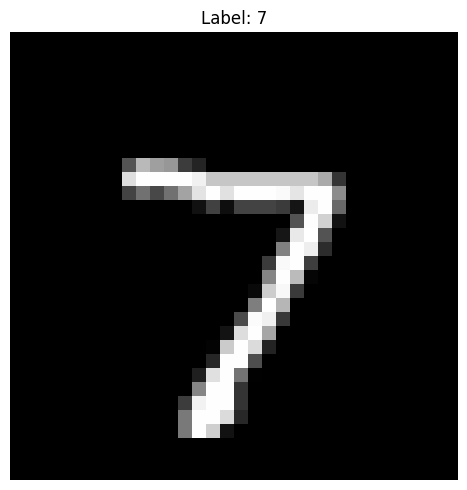

In [23]:
train_loader, test_loader = get_data_loaders()
visualize_random_sample(train_loader)

In [9]:
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.linear_model import Lasso
from skimage.metrics import structural_similarity
from collections import defaultdict
from typing import Dict, List, Tuple

# Constants
MEASUREMENTS = np.arange(10, 1024, 20)
ALPHA = 0.01  # Lasso regularization parameter
THRESHOLDS = (0.3, 0.4)  # Denoising thresholds

def prepare_class_images(train_loader: DataLoader, num_classes: int = 10, images_per_class: int = 10) -> Dict[int, List[torch.Tensor]]:
    """Prepare dictionary with sample images for each class.
    
    Args:
        train_loader: DataLoader with training data
        num_classes: Number of classes to collect
        images_per_class: Number of images per class to collect
        
    Returns:
        Dictionary with class indices as keys and lists of images as values
    """
    class_images = defaultdict(list)
    
    for images, labels in train_loader:
        for img, label in zip(images, labels):
            class_id = label.item()
            if class_id < num_classes and len(class_images[class_id]) < images_per_class:
                class_images[class_id].append(img)
        
        # Early stopping if we have enough images for all classes
        if len(class_images) == num_classes and \
           all(len(v) >= images_per_class for v in class_images.values()):
            break
            
    return dict(class_images)

def spc_transform(image: torch.Tensor, num_measurements: int, alpha: float = ALPHA,
    thresholds: Tuple[float, float] = THRESHOLDS) -> np.ndarray:
    """Perform Sparse Recovery using Lasso.
    
    Args:
        image: Input image tensor (N x N)
        num_measurements: Number of measurements to use
        alpha: Lasso regularization parameter
        thresholds: Denoising thresholds (low, high)
        
    Returns:
        Recovered and denoised image
    """
    # Select measurements
    A = masks_sorted[:num_measurements]
    
    Theta = A @ dct_basis
    x = image.flatten().cpu().numpy()
    y = A @ x
    
    # Lasso regression
    lasso = Lasso(alpha=alpha, max_iter=400000, tol=1e-8)
    lasso.fit(Theta, y)
    s_recovered = lasso.coef_
    
    # Reconstruct image
    x_recovered = dct_basis @ s_recovered
    im_recovered = x_recovered.reshape(32, -1)
    
    # Simple denoising
    im_recovered_denoised = im_recovered.copy()
    im_recovered_denoised[im_recovered_denoised < thresholds[0]] = 0
    im_recovered_denoised[im_recovered_denoised > thresholds[1]] = 1
    
    return im_recovered_denoised

def calculate_pearson_correlation_and_ssim(image: torch.Tensor,num_measurements: int) -> Tuple[float, float]:
    """Calculate Pearson correlation for original and recovered images.
    
    Args:
        image: Input image tensor
        num_measurements: Number of measurements to use
        
    Returns:
        Tuple of (correlation, structural similarity)
    """
    im_np = image.flatten().cpu().numpy()
    
    # Recover images with both methods
    im_rec = spc_transform(image, num_measurements)
    
    return (pearsonr(im_np, im_rec.flatten())[0],
            structural_similarity(im_np, im_rec.flatten(), data_range = 1))

def analyze_class_correlations(class_images: Dict[int, List[torch.Tensor]],
    measurements: np.ndarray = MEASUREMENTS) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Analyze correlations and structural similarity for all classes.
    
    Args:
        class_images: Dictionary of images by class
        measurements: Array of measurement counts to test
        
    Returns:
        Tuple of (avg_pearson, std_pearson, avg_ssim, std_ssim)
    """
    num_classes = len(class_images)
    num_measurements = len(measurements)
    
    # Initialize result arrays
    all_pearson_mean = np.zeros((num_classes, num_measurements))
    all_ssim_mean = np.zeros((num_classes, num_measurements))
    all_pearson_std = np.zeros((num_classes, num_measurements))
    all_ssim_std = np.zeros((num_classes, num_measurements))
    
    for class_idx, images in tqdm(class_images.items(), desc="Processing classes"):
        class_results = []
        class_results_ssim = []
        
        for img in images:
            im = img.reshape(32, -1)
            pearson_vals = []
            ssim_vals = []
            
            for M in measurements:
                coefs = calculate_pearson_correlation_and_ssim(im, M)
                pearson_vals.append(coefs[0])
                ssim_vals.append(coefs[1])
                
            class_results.append(pearson_vals)
            class_results_ssim.append(ssim_vals)
        
        # Store class averages
        all_pearson_mean[class_idx] = np.mean(class_results, axis=0)
        all_ssim_mean[class_idx] = np.mean(class_results_ssim, axis=0)
        all_pearson_std[class_idx] = np.std(class_results, axis=0)
        all_ssim_std[class_idx] = np.std(class_results_ssim, axis=0)

    
    return all_pearson_mean, all_ssim_mean, all_pearson_std, all_ssim_std

def plot_results(class_images: Dict[int, List[torch.Tensor]], avg_pearson: np.ndarray, avg_ssim: np.ndarray,
    std_pearson, std_ssim, measurements: np.ndarray = MEASUREMENTS) -> None:
    """Plot correlation results for all classes.
    
    Args:
        class_images: Dictionary of images by class
        avg_pearson: Average Pearson correlations (ordered)
        avg_ssim: Average structural similarity
        std_pearson: Standard deviation of Pearson correlation
        std_ssim: Standard deviation of structural similarity
        measurements: Array of measurement counts
    """
    num_classes = len(class_images)
    fig, axes = plt.subplots(num_classes, 2, figsize=(20, 5*num_classes), squeeze=False)
    
    for class_idx in range(num_classes):
        # Plot example image
        example_img = class_images[class_idx][0].reshape(32, -1)
        axes[class_idx, 0].imshow(example_img, cmap='gray')
        axes[class_idx, 0].set_title(f'Class {class_idx} (example)')
        axes[class_idx, 0].axis('off')
        
        # Plot correlations
        ax = axes[class_idx, 1]
        ax.plot(measurements, avg_pearson[class_idx], 
               label='Correlation')
        ax.plot(measurements, avg_ssim[class_idx], 
               color='r', label='SSIM')
        ax.fill_between(measurements, 
                avg_pearson[class_idx] - std_pearson[class_idx],
                avg_pearson[class_idx] + std_pearson[class_idx],
                alpha=0.2, color='blue')
        ax.fill_between(measurements, 
            avg_ssim[class_idx] - std_ssim[class_idx],
            avg_ssim[class_idx] + std_ssim[class_idx],
            alpha=0.2, color='r')
        ax.set_title(f'Average Correlation and SSIM for Class {class_idx}')
        ax.set_xlabel('Number of Measurements')
        ax.set_ylabel('Pearson Correlation and Structural Similarity')
        ax.set_ylim(0, 1)
        ax.grid()
        ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
        ax.axhline(y=0.8, color='g', linestyle='--', alpha=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
class_images = prepare_class_images(train_loader)
avg_pearson, avg_ssim, std_pearson, std_ssim = analyze_class_correlations(class_images)
plot_results(class_images, avg_pearson, avg_ssim, std_pearson, std_ssim)

In [11]:
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

def add_blur_noise(image: np.ndarray, noise_type: str = 'gaussian', intensity: float = 0.1, sigma: float = 1.0,
    denoise_thresholds: Tuple[float, float] = THRESHOLDS, clip_range: Tuple[float, float] = (0, 1)) -> np.ndarray:
    """Add blur and noise to image with optional denoising.
    
    Args:
        image: Input image (2D numpy array)
        noise_type: Type of noise to add ('gaussian', 'salt_pepper', 'poisson', 'speckle')
        intensity: Noise intensity (interpretation depends on noise_type)
        sigma: Standard deviation for Gaussian blur
        denoise_thresholds: Thresholds for simple denoising (low, high)
        clip_range: Range to clip final image values
        
    Returns:
        Processed image with same shape as input
    
    Raises:
        ValueError: If invalid noise_type is provided
    """
    # Validate input
    if noise_type not in ['gaussian', 'salt_pepper', 'poisson', 'speckle']:
        raise ValueError(f"Invalid noise_type. Must be one of: 'gaussian', 'salt_pepper', 'poisson', 'speckle'")
    
    if len(image.shape) != 2:
        raise ValueError("Input image must be 2D array")
    
    # Apply Gaussian blur
    blurred = gaussian_filter(image, sigma=sigma)
    
    # Apply selected noise
    if noise_type == 'gaussian':
        noisy = random_noise(blurred, mode='gaussian', var=intensity**2)
    elif noise_type == 'salt_pepper':
        noisy = random_noise(blurred, mode='s&p', amount=intensity)
    elif noise_type == 'poisson':
        noisy = random_noise(blurred, mode='poisson')
    else:  # speckle
        noisy = random_noise(blurred, mode='speckle', var=intensity**2)
    
    # Simple threshold-based denoising
    denoised = noisy.copy()
    denoised[denoised < denoise_thresholds[0]] = 0
    denoised[denoised > denoise_thresholds[1]] = 1
    
    # Clip to specified range
    return np.clip(denoised, *clip_range)

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F


def calculate_metrics(model: nn.Module, data_loader: DataLoader, return_confusion: bool = False):
    """Calculate classification metrics for a model on given data.
    
    Args:
        model: PyTorch model to evaluate
        data_loader: DataLoader with evaluation data
        device: Device to run calculations on
        return_confusion: Whether to return confusion matrix
        
    Returns:
        Tuple with (accuracy, precision, recall, f1) or 
        (accuracy, precision, recall, f1, confusion_matrix) if return_confusion=True
        
    Example:
        >>> accuracy, precision, recall, f1 = calculate_metrics(model, test_loader, device)
    """
    model.eval()
    true_labels = []
    pred_labels = []
    
    # Collect predictions
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())
    
    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(true_labels, pred_labels),
        'precision': precision_score(true_labels, pred_labels, average='macro'),
        'recall': recall_score(true_labels, pred_labels, average='macro'),
        'f1': f1_score(true_labels, pred_labels, average='macro')
    }
    
    # Calculate confusion matrix if requested
    if return_confusion:
        from sklearn.metrics import confusion_matrix
        confusion = confusion_matrix(true_labels, pred_labels)
        return metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1'], confusion
    
    return metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']

In [18]:
from torch.utils.data import Dataset, Subset
from sklearn.model_selection import train_test_split

# Constants
TRANSFORM_TEST_SIZE = 0.1
MEASUREMENTS = np.arange(10, 1024, 10)


class ProcessedMNIST(Dataset):
    """Custom dataset for processed MNIST images with targets."""
    def __init__(self, data: torch.Tensor, targets: torch.Tensor):
        """
        Args:
            data (torch.Tensor): Tensor of processed images
            targets (torch.Tensor): Tensor of corresponding labels
        """
        self.data = data
        self.targets = targets
        
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.data[idx], self.targets[idx]


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2),
])

test_dataset = datasets.MNIST('./data', train=False,download=True,transform=test_transform)

# Split indices
indices = np.arange(len(test_dataset))
standard_idx, transform_idx = train_test_split(indices, test_size=TRANSFORM_TEST_SIZE, random_state=42)

# Create subsets
standard_test = Subset(test_dataset, standard_idx)
transform_test = Subset(test_dataset, transform_idx)

# Create dataloaders
test_loader = DataLoader(
    standard_test, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True, 
    num_workers=NUM_WORKERS
)

transform_loader = DataLoader(
    transform_test, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True, 
    num_workers=NUM_WORKERS
)

def create_processed_dataset(
    dataset: Subset,
    measurement: int,
    name: str,
    processing_type: str = 'spc',
    random_measurement: bool = False,
    save: bool = True,
) -> ProcessedMNIST:
    """Create processed dataset with specified transformations.
    
    Args:
        dataset: Input dataset to process
        measurement: Measurement parameter M
        name: Name of the file
        processing_type: Type of processing to apply
        random_measurement: Whether to use random measurements
        save: Whether to save the processed dataset
        
    Returns:
        ProcessedMNIST dataset
    """
    # Collect all images and labels
    images, labels = [], []
    for img, label in dataset:
        images.append(img)
        labels.append(label)
    
    images = torch.stack(images)
    labels = torch.tensor(labels)
    
    # Process images
    processed_images = []
    for img in tqdm(images, desc=f'Processing M={measurement}'):
        img = img.unsqueeze(0).to(device)  # Add channel dim
        
        if processing_type == 'vector':
            if random_measurement:
                current_m = np.random.randint(10, 1024)
                processed_img = torch.tensor(SPC_output(img, current_m))
            else:
                processed_img = torch.tensor(SPC_output(img, measurement))
        elif processing_type == 'noisy':
            processed_img = torch.tensor(add_blur_noise(img.cpu()))
        elif processing_type == 'noisy_spc':
            noisy_img = torch.tensor(add_blur_noise(img.cpu()))
            processed_img = torch.tensor(spc_transform(noisy_img, measurement))
        else:  # 'spc'
            processed_img = torch.tensor(spc_transform(img, measurement))
        
        processed_images.append(processed_img.cpu())
    
    # Create dataset
    processed_data = torch.stack(processed_images)
    processed_dataset = ProcessedMNIST(processed_data, labels)
    
    # Save if requested
    if save:
        # Generate descriptive filename
        name += f"_MNIST_{processing_type}"
        if random_measurement and processing_type == 'vector':
            name += "_random"
        name += f"_M{measurement}.pt"
        
        torch.save(processed_dataset, name)
        print(f"Dataset saved to {name }")
    
    return processed_dataset

In [76]:
# Constants
LEARNING_RATE = 1e-3
EPOCHS = 10

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    save_path: str
) -> Tuple[float, float]:
    """Train and evaluate a model.
    
    Args:
        model: Model to train
        train_loader: Training data loader
        test_loader: Test data loader
        save_path: Name of the model
        
    Returns:
        Tuple of (best_train_accuracy, final_test_accuracy)
    """
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    best_accuracy = 0.0

    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        
        # Evaluation
        train_accuracy, *_ = calculate_metrics(model, train_loader)
        test_accuracy, *_ = calculate_metrics(model, test_loader)
        if epoch % 3 == 0:
            print(f'\nEpoch {epoch+1} Results:')
            print(f'Train Accuracy: {train_accuracy:.4f}')
            print(f'Test Accuracy: {test_accuracy:.4f}')
        
        # Save best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model, save_path)

    return train_accuracy, test_accuracy

def analyze_model_accuracy(
    model: nn.Module,
    show_plot: bool = True
) -> Dict[str, List[float]]:
    """Analyze model accuracy across different measurements.
    
    Args:
        model: Model to evaluate
        show_plot: Whether to display results plot
        
    Returns:
        Dictionary of metric lists {'accuracy': [...], 'precision': [...], ...}
    """
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    for M in tqdm(MEASUREMENTS, desc="Analyzing measurements"):
        # Load dataset
        dataset_path = f"MNIST transform_testfor m = {M}.pt"
        transform_test = torch.load(dataset_path, weights_only=False)
        transform_test.data = transform_test.data.float()
        transform_loader = DataLoader(
            transform_test,
            batch_size=BATCH_SIZE,
            shuffle=False,
            pin_memory=True,
            num_workers=NUM_WORKERS
        )
        
        # Calculate metrics
        acc, prec, rec, f1 = calculate_metrics(model, transform_loader)
        metrics['accuracy'].append(acc)
        metrics['precision'].append(prec)
        metrics['recall'].append(rec)
        metrics['f1'].append(f1)
        if M%100 == 0:
            print(f'\nMetrics for M={M}:')
            print(f'Accuracy: {acc:.4f}')
            print(f'Precision: {prec:.4f}')
            print(f'Recall: {rec:.4f}')
            print(f'F1: {f1:.4f}')
        
    # Plot results
    if show_plot:
        plt.figure(figsize=(8, 8))
        plt.plot(MEASUREMENTS, metrics['accuracy'], label='Accuracy', color='royalblue')
        plt.plot(MEASUREMENTS, metrics['f1'], label='F1-score', color='crimson')
        
        plt.xlabel('Number of SPC Measurements', fontsize=12)
        plt.ylabel('Metric Value', fontsize=12)
        plt.title('Model Performance vs SPC Measurements', fontsize=14)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()
    
    return metrics

def analyze_class_probabilities(
    model: nn.Module,
    target_class: int,
    class_names: List[str],
    loader: DataLoader = None,
    num_samples: int = 25,
    top_n: int = 4
) -> Dict[int, Dict[str, List[float]]]:
    """Analyze class probabilities across measurements.
    
    Args:
        model: Model to evaluate
        target_class: Class index to analyze
        class_names: List of class names
        loader: DataLoader or None
        num_samples: Number of samples per class
        top_n: Number of top classes to display
        dataset:
        
    Returns:
        Dictionary of class statistics
    """
    stats = {i: {'avg_probs': [], 'std_probs': []} for i in range(len(class_names))}
    
    for M in tqdm(MEASUREMENTS, desc="Processing measurements"):
        # Load dataset
        if not loader:
            dataset = torch.load(f"MNIST transform_testfor m = {M}.pt", weights_only=False)
            dataset.data = dataset.data.float()
            loader = DataLoader(
                dataset,
                batch_size=BATCH_SIZE,
                shuffle=False,
                pin_memory=True,
                num_workers=NUM_WORKERS
            )
        
        # Collect predictions
        class_probs = defaultdict(list)
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                probs = F.softmax(outputs, dim=1) * 100
                
                for prob, label in zip(probs, labels):
                    if len(class_probs[label.item()]) < num_samples:
                        class_probs[label.item()].append(prob[target_class].item())
                
                if all(len(v) >= num_samples for v in class_probs.values()):
                    break
        
        # Calculate statistics
        for class_id in range(len(class_names)):
            samples = class_probs.get(class_id, [])
            stats[class_id]['avg_probs'].append(np.mean(samples) if samples else 0)
            stats[class_id]['std_probs'].append(np.std(samples) if samples else 0)
    
    # Visualize top classes
    top_classes = sorted(
        [(i, np.mean(stats[i]['avg_probs'])) for i in range(len(class_names))],
        key=lambda x: -x[1]
    )[:top_n]
    
    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab10.colors
    
    for idx, (class_id, _) in enumerate(top_classes):
        avg = stats[class_id]['avg_probs']
        std = stats[class_id]['std_probs']
        
        plt.plot(MEASUREMENTS, avg, 
                label=f'{class_names[class_id]}',
                color=colors[class_id])
        plt.fill_between(MEASUREMENTS,
                       np.array(avg) - np.array(std),
                       np.array(avg) + np.array(std),
                       alpha=0.2,
                       color=colors[class_id])
    
    plt.xlabel('Number of SPC Measurements')
    plt.ylabel('Probability (%)')
    plt.title(f'Probability for Class {class_names[target_class]}\n({num_samples} samples)')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()
    
    return stats

In [68]:
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

class MLP(nn.Module):
    def __init__(self, input_dim: int = 32*32, dtype:torch.dtype = None):
        """
        Multi-Layer Perceptron for classification.
        
        Args:
            input_dim: Dimension of input features (default 32*32)
            dtype: Data type for model parameters (default torch.float32)
        """
        super().__init__()
        self.dtype = dtype if dtype is not None else torch.float32
        
        self.ll1 = nn.Linear(input_dim, 256)
        self.ll2 = nn.Linear(256, 64)
        self.ll3 = nn.Linear(64, 10)
        
        # Initialize weights properly
        self._initialize_weights()
        
        # Convert to specified dtype
        self.to(self.dtype)
        
    def _initialize_weights(self):
        """Initialize weights with Kaiming normal and zeros for biases."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network.
        
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
            
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        # Ensure input dtype matches model dtype
        if x.dtype != self.dtype:
            x = x.to(self.dtype)
            
        # Flatten and process through layers
        x = x.view(-1, self.ll1.in_features)  # Flatten to (batch_size, input_dim)
        x = F.relu(self.ll1(x))
        x = F.relu(self.ll2(x))
        x = self.ll3(x)
        return x

In [74]:
def train_and_analyze(
    architecture: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    name: str,
    measurements: np.ndarray = np.arange(10, 1024, 10),
    vec: bool = False,
) -> Tuple[List[float], float, float, torch.nn.Module]:
    """
    Complete training and analysis pipeline for a model.
    
    Args:
        architecture: Model architecture to train
        train_loader: Training data loader
        test_loader: Test data loader
        name: Base name for saving model
        measurements: Array of measurement values for analysis
        vec: Whether to use vector datasets for analysis
        
    Returns:
        Tuple containing:
        - accuracy_list: List of accuracy values for different measurements
        - train_accuracy: Final training accuracy
        - test_accuracy: Final test accuracy
        - model: Trained model
    """
    model = architecture.to(device)
    train_accuracy, test_accuracy = train_model(model, train_loader, test_loader, save_path=name)
    accuracy_lst = analyze_model_accuracy(model)['accuracy']
    return accuracy_lst, train_accuracy, test_accuracy, model


Epoch 1 Results:
Train Accuracy: 0.8951
Test Accuracy: 0.8196

Epoch 4 Results:
Train Accuracy: 0.9898
Test Accuracy: 0.8647

Epoch 7 Results:
Train Accuracy: 1.0000
Test Accuracy: 0.8834

Epoch 10 Results:
Train Accuracy: 1.0000
Test Accuracy: 0.8810


Analyzing measurements:   0%|          | 0/102 [00:00<?, ?it/s]c:\Users\Ruslan Khalikov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ruslan Khalikov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ruslan Khalikov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi


Metrics for M=100:
Accuracy: 0.7670
Precision: 0.7696
Recall: 0.7718
F1: 0.7666


Analyzing measurements:  24%|██▎       | 24/102 [00:01<00:03, 20.10it/s]


Metrics for M=200:
Accuracy: 0.9010
Precision: 0.8989
Recall: 0.9014
F1: 0.8998


Analyzing measurements:  32%|███▏      | 33/102 [00:01<00:03, 21.47it/s]


Metrics for M=300:
Accuracy: 0.8980
Precision: 0.8989
Recall: 0.8975
F1: 0.8978


Analyzing measurements:  41%|████      | 42/102 [00:01<00:02, 21.50it/s]


Metrics for M=400:
Accuracy: 0.9030
Precision: 0.9021
Recall: 0.9036
F1: 0.9026


Analyzing measurements:  53%|█████▎    | 54/102 [00:02<00:02, 20.95it/s]


Metrics for M=500:
Accuracy: 0.8910
Precision: 0.8908
Recall: 0.8899
F1: 0.8899


Analyzing measurements:  62%|██████▏   | 63/102 [00:02<00:01, 20.23it/s]


Metrics for M=600:
Accuracy: 0.8860
Precision: 0.8859
Recall: 0.8841
F1: 0.8847


Analyzing measurements:  71%|███████   | 72/102 [00:03<00:01, 19.47it/s]


Metrics for M=700:
Accuracy: 0.8830
Precision: 0.8847
Recall: 0.8818
F1: 0.8828


Analyzing measurements:  81%|████████▏ | 83/102 [00:04<00:00, 19.96it/s]


Metrics for M=800:
Accuracy: 0.8840
Precision: 0.8858
Recall: 0.8839
F1: 0.8843


Analyzing measurements:  88%|████████▊ | 90/102 [00:04<00:00, 19.71it/s]


Metrics for M=900:
Accuracy: 0.8720
Precision: 0.8754
Recall: 0.8718
F1: 0.8721


Analyzing measurements: 100%|██████████| 102/102 [00:05<00:00, 20.05it/s]



Metrics for M=1000:
Accuracy: 0.8830
Precision: 0.8874
Recall: 0.8821
F1: 0.8834


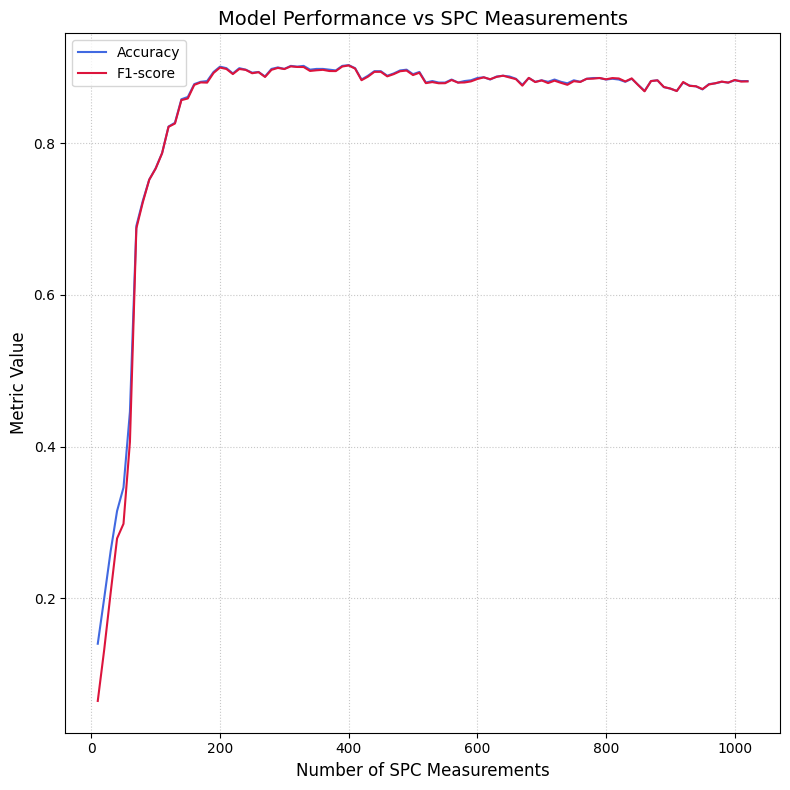


Epoch 1 Results:
Train Accuracy: 0.9042
Test Accuracy: 0.8344

Epoch 4 Results:
Train Accuracy: 0.9949
Test Accuracy: 0.8834

Epoch 7 Results:
Train Accuracy: 1.0000
Test Accuracy: 0.8896

Epoch 10 Results:
Train Accuracy: 1.0000
Test Accuracy: 0.8927


Analyzing measurements:   0%|          | 0/102 [00:00<?, ?it/s]c:\Users\Ruslan Khalikov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Analyzing measurements:  15%|█▍        | 15/102 [00:00<00:03, 27.57it/s]


Metrics for M=100:
Accuracy: 0.7380
Precision: 0.7437
Recall: 0.7469
F1: 0.7363


Analyzing measurements:  24%|██▎       | 24/102 [00:00<00:03, 24.77it/s]


Metrics for M=200:
Accuracy: 0.8790
Precision: 0.8765
Recall: 0.8808
F1: 0.8779


Analyzing measurements:  32%|███▏      | 33/102 [00:01<00:02, 23.64it/s]


Metrics for M=300:
Accuracy: 0.8700
Precision: 0.8672
Recall: 0.8720
F1: 0.8686


Analyzing measurements:  41%|████      | 42/102 [00:01<00:02, 23.57it/s]


Metrics for M=400:
Accuracy: 0.8920
Precision: 0.8897
Recall: 0.8927
F1: 0.8906


Analyzing measurements:  53%|█████▎    | 54/102 [00:02<00:02, 23.40it/s]


Metrics for M=500:
Accuracy: 0.9010
Precision: 0.8994
Recall: 0.9018
F1: 0.9003


Analyzing measurements:  59%|█████▉    | 60/102 [00:02<00:01, 23.62it/s]


Metrics for M=600:
Accuracy: 0.8940
Precision: 0.8923
Recall: 0.8939
F1: 0.8925


Analyzing measurements:  71%|███████   | 72/102 [00:03<00:01, 17.60it/s]


Metrics for M=700:
Accuracy: 0.8940
Precision: 0.8940
Recall: 0.8935
F1: 0.8930


Analyzing measurements:  80%|████████  | 82/102 [00:03<00:01, 18.03it/s]


Metrics for M=800:
Accuracy: 0.8940
Precision: 0.8966
Recall: 0.8953
F1: 0.8948


Analyzing measurements:  90%|█████████ | 92/102 [00:04<00:00, 16.55it/s]


Metrics for M=900:
Accuracy: 0.8820
Precision: 0.8837
Recall: 0.8827
F1: 0.8818


Analyzing measurements: 100%|██████████| 102/102 [00:04<00:00, 20.52it/s]


Metrics for M=1000:
Accuracy: 0.8770
Precision: 0.8829
Recall: 0.8759
F1: 0.8764


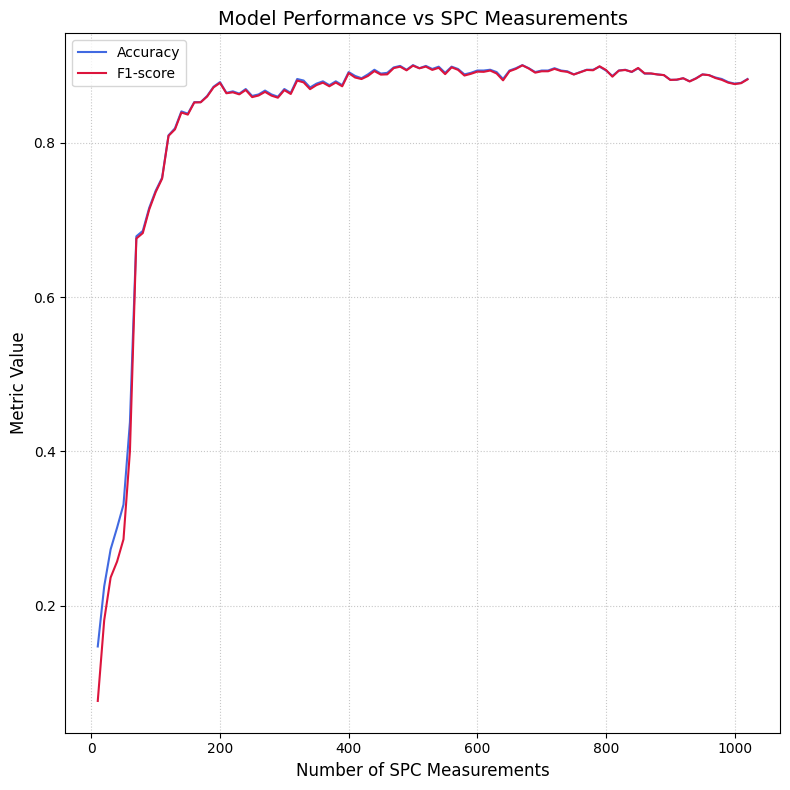


Epoch 1 Results:
Train Accuracy: 0.9048
Test Accuracy: 0.8484

Epoch 4 Results:
Train Accuracy: 0.9929
Test Accuracy: 0.8872

Epoch 7 Results:
Train Accuracy: 1.0000
Test Accuracy: 0.9082

Epoch 10 Results:
Train Accuracy: 1.0000
Test Accuracy: 0.9059


Analyzing measurements:   0%|          | 0/102 [00:00<?, ?it/s]c:\Users\Ruslan Khalikov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Analyzing measurements:  13%|█▎        | 13/102 [00:00<00:03, 27.73it/s]


Metrics for M=100:
Accuracy: 0.7310
Precision: 0.7335
Recall: 0.7369
F1: 0.7283


Analyzing measurements:  25%|██▌       | 26/102 [00:00<00:02, 27.94it/s]


Metrics for M=200:
Accuracy: 0.8620
Precision: 0.8606
Recall: 0.8647
F1: 0.8606


Analyzing measurements:  31%|███▏      | 32/102 [00:01<00:03, 22.93it/s]


Metrics for M=300:
Accuracy: 0.8590
Precision: 0.8569
Recall: 0.8615
F1: 0.8574


Analyzing measurements:  43%|████▎     | 44/102 [00:01<00:02, 24.45it/s]


Metrics for M=400:
Accuracy: 0.8820
Precision: 0.8801
Recall: 0.8821
F1: 0.8804


Analyzing measurements:  52%|█████▏    | 53/102 [00:02<00:02, 24.07it/s]


Metrics for M=500:
Accuracy: 0.8980
Precision: 0.8958
Recall: 0.8996
F1: 0.8969


Analyzing measurements:  64%|██████▎   | 65/102 [00:02<00:01, 24.00it/s]


Metrics for M=600:
Accuracy: 0.9090
Precision: 0.9077
Recall: 0.9088
F1: 0.9079


Analyzing measurements:  73%|███████▎  | 74/102 [00:03<00:01, 23.53it/s]


Metrics for M=700:
Accuracy: 0.9120
Precision: 0.9120
Recall: 0.9115
F1: 0.9110


Analyzing measurements:  81%|████████▏ | 83/102 [00:03<00:00, 21.66it/s]


Metrics for M=800:
Accuracy: 0.9130
Precision: 0.9131
Recall: 0.9142
F1: 0.9131


Analyzing measurements:  90%|█████████ | 92/102 [00:03<00:00, 17.75it/s]


Metrics for M=900:
Accuracy: 0.9090
Precision: 0.9113
Recall: 0.9099
F1: 0.9099


Analyzing measurements: 100%|██████████| 102/102 [00:04<00:00, 22.90it/s]


Metrics for M=1000:
Accuracy: 0.9150
Precision: 0.9183
Recall: 0.9145
F1: 0.9152


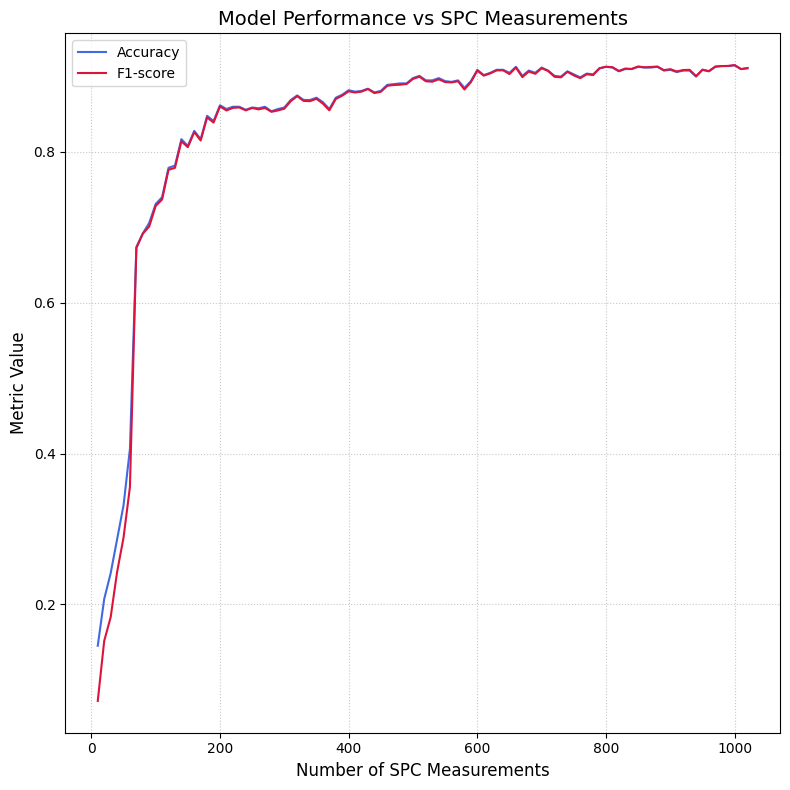

In [77]:
processed_m = [200, 400, 600]
accuracy_lsts = []
models = []

for M in processed_m:    
    dataset = torch.load(f"train_datasetMNIST_spc_M{M}.pt", weights_only = False)
    indices = np.arange(len(dataset))
    train_idx, test_idx = train_test_split(indices, test_size=1/7, random_state=42)

    train_dataset_ = Subset(dataset, train_idx)
    test_dataset_ = Subset(dataset, test_idx)

    train_loader_ = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
    test_loader_ = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)
    accuracy_lst, _, _, model = train_and_analyze(MLP(), train_loader_, test_loader_, f"Model for M = {M}")
    accuracy_lsts.append(accuracy_lst)
    models.append(model)